In [1]:
import sys
from os.path import join, abspath
from glob import glob
import numpy as np
import vaex
from tqdm import tqdm
import matplotlib.pyplot as plt
from time import time
from scipy.stats import norm, uniform

In [2]:
# import utils
root_dir = abspath(join('..'))
root_dir

'/home2/s20321005/Thesis-Project'

In [3]:
if root_dir not in sys.path:
    sys.path.append(root_dir)
sys.path

['/home2/s20321005/Thesis-Project/6_Analisis',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages',
 '/home2/s20321005/Thesis-Project']

In [42]:
from utils import style, hdi, find_max

In [5]:
style()

In [6]:
root_data_dir = abspath(join(root_dir, "Data"))
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

In [7]:
data_baryon_dir = join(root_data_dir, "Baryon")
# load baryons components
df_baryon = vaex.open(join(data_baryon_dir, "baryon.hdf5"))
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

e_rhos = df_baryon["e_rho"].to_numpy()  # Msun/pc^3
e_sigmaz = df_baryon["e_sigma_z"].to_numpy() # km/s
dpi=100

# $z$ variations

In [8]:
tipe = "z"
zfiles = glob(join(root_data_dir, 'MCMC', 'dm_mock', 'mock', tipe, 'z*.hdf5'))
zfiles.sort()
wfiles = glob(join(root_data_dir, 'MCMC', 'dm_mock', 'mock', tipe, 'w*.hdf5'))
wfiles.sort()

In [9]:
# for model 2 (double gaussia)
dm_2_files = glob(join(join(root_data_dir, 'MCMC', 'dm_mock', tipe, 'data', "chain-2-*")))
dm_2_files.sort()
dm_2_files

['/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/z/data/chain-2-0.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/z/data/chain-2-1.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/z/data/chain-2-2.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/z/data/chain-2-3.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/z/data/chain-2-4.npy']

In [10]:
index = 0
df = np.load(dm_2_files[index])
df.shape

(20000, 68, 33)

In [11]:
from scipy.stats import norm

rhob = df[:, :, :12]
rhob = rhob.reshape(-1, 12)
rhob = rhob.sum(axis=1)/1E-2
rhoDM = df[:, :, 24].reshape(-1)/1E-2
length = len(rhob)
rhob0 = np.empty((length, 12))
for i in range(12):
    rhob0[:,i] = norm.rvs(loc=rhos[i], scale=e_rhos[i], size=length)
rhob0 = rhob0.sum(axis=1)/1E-2

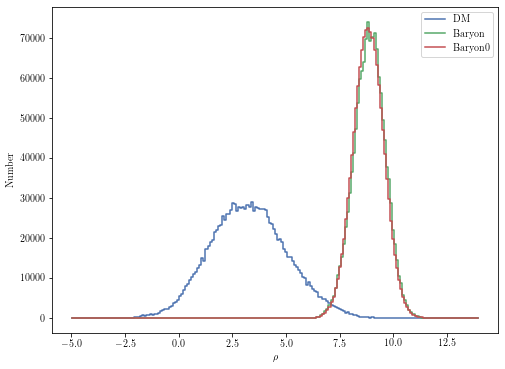

In [12]:
rho = np.linspace(-5, 14, 200)
rhoDM_num, _ = np.histogram(rhoDM, bins=rho)
rhob_num, _ = np.histogram(rhob, bins=rho)
rhob0_num, _ = np.histogram(rhob0, bins=rho)
rhomid = 0.5*(rho[1:] + rho[:-1])
# plot step
fig, ax = plt.subplots(figsize=(8, 6))
ax.step(rhomid, rhoDM_num, label='DM')
ax.step(rhomid, rhob_num, label='Baryon')
ax.step(rhomid, rhob0_num, label='Baryon0')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel('Number')
ax.legend()
plt.show()

In [39]:
from scipy.stats import skewnorm
rhoDM_sample = np.random.choice(rhoDM, size=2000, replace=False)
rhoDM_fit = skewnorm.fit(rhoDM_sample)
rhob_sample = np.random.choice(rhob, size=2000, replace=False)
rhob_fit = skewnorm.fit(rhob_sample)
rhob0_sample = np.random.choice(rhob0, size=2000, replace=False)
rhob0_fit = norm.fit(rhob0_sample)

((1.1750501702340639, 1.9935818741555713, 2.2831084489648132),
 (-0.4331766998921168, 9.195401001428213, 0.769177637152901),
 (8.882412563009808, 0.7169443592723607))

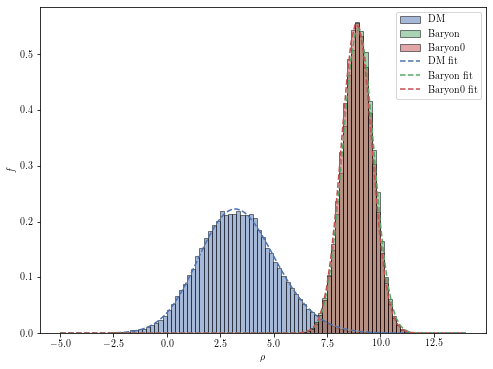

In [41]:
# plot
rho = np.linspace(-5, 14, 100)
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(rhoDM, bins=rho, density=True, label='DM', ec='k', alpha=0.5, color='C0')
ax.hist(rhob, bins=rho, density=True, label='Baryon', ec='k', alpha=0.5,color='C1')
ax.hist(rhob0, bins=rho, density=True, label='Baryon0', ec='k', alpha=0.5, color='C2')
ax.plot(rho, skewnorm.pdf(rho, *rhoDM_fit), label='DM fit', color='C0',  ls='--')
ax.plot(rho, skewnorm.pdf(rho, *rhob_fit), label='Baryon fit', color='C1', ls='--')
ax.plot(rho, norm.pdf(rho, *rhob0_fit), label='Baryon0 fit', color='C2', ls='--')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$f$')
ax.legend()
rhoDM_fit, rhob_fit, rhob0_fit

rhoDM = 3.20 +1.86/-1.73
rhob = 8.96 +0.73/-0.74
rhob0 = 8.88 +0.71/-0.72


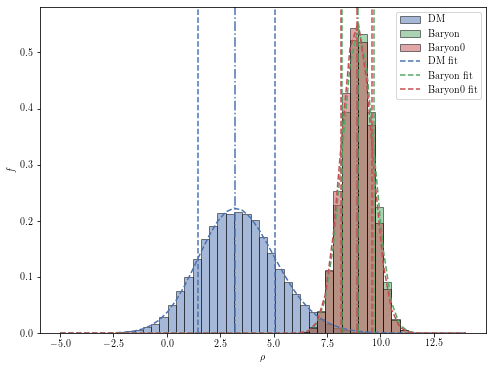

In [43]:
rhoDM_low, rhoDM_high = hdi(lambda x: skewnorm.pdf(x, *rhoDM_fit), perc=0.68, res=1E3, min=-5, max=14)
rhoDM_mode = find_max(lambda x: skewnorm.pdf(x, *rhoDM_fit), x0=0.0)[0]

rhob_low, rhob_high = hdi(lambda x: skewnorm.pdf(x, *rhob_fit), perc=0.68, res=1E3, min=-5, max=14)
rhob_mode = find_max(lambda x: skewnorm.pdf(x, *rhob_fit), x0=0.0)[0]

rhob0_low, rhob0_high = hdi(lambda x: norm.pdf(x, *rhob0_fit), perc=0.68, res=1E3, min=-5, max=14)
rhob0_mode = find_max(lambda x: norm.pdf(x, *rhob0_fit), x0=0.0)[0]

# plot
rho = np.linspace(-5, 14, 50)
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(rhoDM, bins=rho, density=True, label='DM', ec='k', alpha=0.5, color='C0')
ax.hist(rhob, bins=rho, density=True, label='Baryon', ec='k', alpha=0.5,color='C1')
ax.hist(rhob0, bins=rho, density=True, label='Baryon0', ec='k', alpha=0.5, color='C2')
ax.plot(rho, skewnorm.pdf(rho, *rhoDM_fit), label='DM fit', color='C0',  ls='--')
ax.plot(rho, skewnorm.pdf(rho, *rhob_fit), label='Baryon fit', color='C1', ls='--')
ax.plot(rho, norm.pdf(rho, *rhob0_fit), label='Baryon0 fit', color='C2', ls='--')
ax.axvline(rhoDM_mode, color='C0', ls='-.')
ax.axvline(rhob_mode, color='C1', ls='-.')
ax.axvline(rhob0_mode, color='C2', ls='-.')
ax.axvline(rhoDM_low, color='C0', ls='--')
ax.axvline(rhoDM_high, color='C0', ls='--')
ax.axvline(rhob_low, color='C1', ls='--')
ax.axvline(rhob_high, color='C1', ls='--')
ax.axvline(rhob0_low, color='C2', ls='--')
ax.axvline(rhob0_high, color='C2', ls='--')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$f$')
ax.legend()
print(f'rhoDM = {rhoDM_mode:.02f} +{rhoDM_high-rhoDM_mode:.02f}/-{rhoDM_mode-rhoDM_low:.02f}')
print(f'rhob = {rhob_mode:.02f} +{rhob_high-rhob_mode:.02f}/-{rhob_mode-rhob_low:.02f}')
print(f'rhob0 = {rhob0_mode:.02f} +{rhob0_high-rhob0_mode:.02f}/-{rhob0_mode-rhob0_low:.02f}')

rhob0 = 8.89 +0.71/-0.71


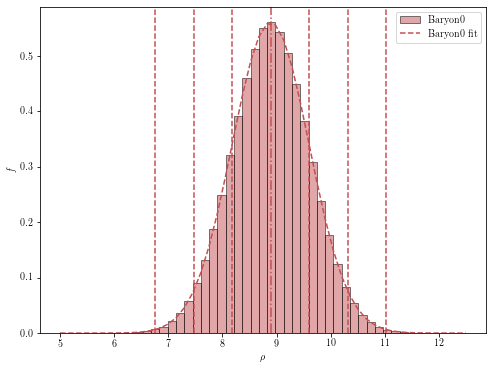

In [46]:
length = len(rhob)
rhob0 = np.empty((length, 12))
for i in range(12):
    rhob0[:,i] = norm.rvs(loc=rhos[i], scale=e_rhos[i], size=length)
rhob0 = rhob0.sum(axis=1)/1E-2
# fit with gaussian
rhob0_fit = norm.fit(rhob0)
# mode
rhob0_mode = find_max(lambda x: norm.pdf(x, *rhob0_fit), x0=0.0)[0]
# find 
sigma_1 = 68.268949/100
sigma_2 = 95.449973/100
sigma_3 = 99.730021/100
rhob0_low = {}
rhob0_high = {}
for i, sigma in enumerate([sigma_1, sigma_2, sigma_3]):
    low, high = hdi(lambda x: norm.pdf(x, *rhob0_fit), perc=sigma, res=1E3, min=5, max=13)
    rhob0_low[i] = low
    rhob0_high[i] = high
# plot
rho = np.linspace(5, 12.5, 50)
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(rhob0, bins=rho, density=True, label='Baryon0', ec='k', alpha=0.5, color='C2')
ax.plot(rho, norm.pdf(rho, *rhob0_fit), label='Baryon0 fit', color='C2', ls='--')
ax.axvline(rhob0_mode, color='C2', ls='-.')
for i in range(3):
    ax.axvline(rhob0_low[i], color='C2', ls='--')
    ax.axvline(rhob0_high[i], color='C2', ls='--')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$f$')
ax.legend()
print(f'rhob0 = {rhob0_mode:.02f} +{rhob0_high[0]-rhob0_mode:.02f}/-{rhob0_mode-rhob0_low[0]:.02f}')

In [75]:
from tqdm import tqdm

rhoDM_modes = []
rhoDM_errs = []
rhob_modes = []
rhob_errs = []

for index in tqdm(range(len(dm_2_files))):
    df = np.load(dm_2_files[index])
    rhob = df[:, :, :12]
    rhob = rhob.reshape(-1, 12)
    rhob = rhob.sum(axis=1)/1E-2
    rhoDM = df[:, :, 24].reshape(-1)/1E-2
    print("fitting...")
    rhoDM_sample = np.random.choice(rhoDM, size=2000, replace=False)
    rhoDM_fit = skewnorm.fit(rhoDM_sample)
    rhob_sample = np.random.choice(rhob, size=2000, replace=False)
    rhob_fit = skewnorm.fit(rhob_sample)

    print("calculating HDI...")
    rhoDM_low = {}
    rhoDM_high = {}
    rhob_low = {}
    rhob_high = {}
    for i, sigma in enumerate([sigma_1, sigma_2, sigma_3]):
        low, high = hdi(lambda x: skewnorm.pdf(x, *rhoDM_fit), perc=sigma, res=1E3, min=-5, max=15)
        rhoDM_low[i] = low
        rhoDM_high[i] = high
        low, high = hdi(lambda x: skewnorm.pdf(x, *rhob_fit), perc=sigma, res=1E3, min=5, max=13)
        rhob_low[i] = low
        rhob_high[i] = high
    print("calculating mode")
    rhoDM_mode = find_max(lambda x: skewnorm.pdf(x, *rhoDM_fit), x0=0.0)[0]
    rhob_mode = find_max(lambda x: skewnorm.pdf(x, *rhob_fit), x0=0.0)[0]
    rhoDM_modes.append(rhoDM_mode)
    rhoDM_errs.append({'low': rhoDM_low, 'high': rhoDM_high})
    rhob_modes.append(rhob_mode)
    rhob_errs.append({'low': rhob_low, 'high': rhob_high})

  0%|          | 0/5 [00:00<?, ?it/s]

fitting...
calculating HDI...


 20%|██        | 1/5 [00:05<00:20,  5.11s/it]

calculating mode
fitting...
calculating HDI...


 40%|████      | 2/5 [00:10<00:15,  5.26s/it]

calculating mode
fitting...
calculating HDI...


 60%|██████    | 3/5 [00:16<00:11,  5.51s/it]

calculating mode
fitting...
calculating HDI...


 80%|████████  | 4/5 [00:21<00:05,  5.38s/it]

calculating mode
fitting...
calculating HDI...


100%|██████████| 5/5 [00:27<00:00,  5.41s/it]

calculating mode


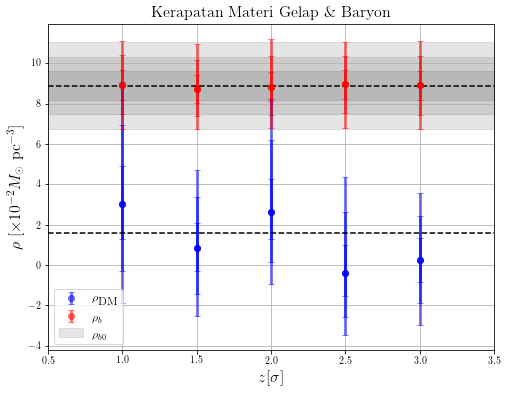

In [102]:
zlevel = np.arange(1, 3.1, 0.5)
zs = np.linspace(0.5, 3.5, 100)

fig, ax = plt.subplots(figsize=(8, 6))
ax.axhline(y=rhob0_mode, color='black', linestyle='--')
for i in range(3):
    low = np.array([err['low'][i] for err in rhoDM_errs])
    high = np.array([err['high'][i] for err in rhoDM_errs])
    dm_ax = ax.errorbar(zlevel, rhoDM_modes, yerr=[rhoDM_modes-low, high-rhoDM_modes], fmt='o', color='blue', capsize=3, alpha=0.5, elinewidth=3, markeredgewidth=1)
    low = np.array([err['low'][i] for err in rhob_errs])
    high = np.array([err['high'][i] for err in rhob_errs])
    rhob_ax = ax.errorbar(zlevel, rhob_modes, yerr=[rhob_modes-low, high-rhob_modes], fmt='o', color='red', capsize=3, alpha=0.5, elinewidth=3, markeredgewidth=1)
    rhob0_ax = ax.fill_between(zs, rhob0_low[i], rhob0_high[i], color='black', alpha=0.1)
    if i == 2:
        ax.legend([dm_ax, rhob_ax, rhob0_ax], 
                  [r'$\rho_{\textup{DM}}$', r'$\rho_{b}$', r'$\rho_{b0}$'],
                  loc='lower left', fontsize=12)
# real value
ax.axhline(y=1.6, color='black', linestyle='--')
ax.set_xlabel(r'$z [\sigma]$', fontsize=16)
ax.set_ylabel(r'$\rho$ [$\times 10^{-2}M_{\odot}\ $pc$^{-3}$]', fontsize=16)
ax.set_xlim(zs.min(), zs.max())
ax.set_title("Kerapatan Materi Gelap \& Baryon", fontsize=16)
ax.grid()
# fig.savefig('rm_2_z.pdf', dpi=300)
plt.show()

In [94]:
# for i in range(5):
#     print(f"{rhoDM_mode[i]:.2f} & [{rhoDM_low68[i]:.2f}, {rhoDM_high68[i]:.2f}] & [{rhoDM_low90[i]:.2f}, {rhoDM_high90[i]:.2f}] & [{rhoDM_low95[i]:.2f}, {rhoDM_high95[i]:.2f}] \\\\")

# $N$

In [103]:
tipe = "n"
zfiles = glob(join(root_data_dir, 'MCMC', 'dm_mock', 'mock', tipe, 'z*.hdf5'))
zfiles.sort()
wfiles = glob(join(root_data_dir, 'MCMC', 'dm_mock', 'mock', tipe, 'w*.hdf5'))
wfiles.sort()

In [105]:
dm_2_files = glob(join(join(root_data_dir, 'MCMC', 'dm_mock',tipe, 'data', "chain-2-*")))
dm_2_files.sort()
dm_2_files

['/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/n/data/chain-2-0.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/n/data/chain-2-1.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/n/data/chain-2-2.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/n/data/chain-2-3.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/n/data/chain-2-4.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/n/data/chain-2-5.npy']

In [110]:
length = len(rhob)
rhob0 = np.empty((length, 12))
for i in range(12):
    rhob0[:,i] = norm.rvs(loc=rhos[i], scale=e_rhos[i], size=length)
rhob0 = rhob0.sum(axis=1)/1E-2
# fit with gaussian
rhob0_fit = norm.fit(rhob0)
# mode
rhob0_mode = find_max(lambda x: norm.pdf(x, *rhob0_fit), x0=0.0)[0]
# find 
sigma_1 = 68/100
sigma_2 = 90/100
sigma_3 = 95/100
rhob0_low = {}
rhob0_high = {}
for i, sigma in enumerate([sigma_1, sigma_2, sigma_3]):
    low, high = hdi(lambda x: norm.pdf(x, *rhob0_fit), perc=sigma, res=1E3, min=5, max=13)
    rhob0_low[i] = low
    rhob0_high[i] = high
# plot
rho = np.linspace(5, 12.5, 50)
print(f'rhob0 = {rhob0_mode:.02f} +{rhob0_high[0]-rhob0_mode:.02f}/-{rhob0_mode-rhob0_low[0]:.02f}')

rhob0 = 8.89 +0.71/-0.71


In [111]:
from tqdm import tqdm

rhoDM_modes = []
rhoDM_errs = []
rhob_modes = []
rhob_errs = []

for index in tqdm(range(len(dm_2_files))):
    df = np.load(dm_2_files[index])
    rhob = df[:, :, :12]
    rhob = rhob.reshape(-1, 12)
    rhob = rhob.sum(axis=1)/1E-2
    rhoDM = df[:, :, 24].reshape(-1)/1E-2
    print("fitting...")
    rhoDM_sample = np.random.choice(rhoDM, size=2000, replace=False)
    rhoDM_fit = skewnorm.fit(rhoDM_sample)
    rhob_sample = np.random.choice(rhob, size=2000, replace=False)
    rhob_fit = skewnorm.fit(rhob_sample)

    print("calculating HDI...")
    rhoDM_low = {}
    rhoDM_high = {}
    rhob_low = {}
    rhob_high = {}
    for i, sigma in enumerate([sigma_1, sigma_2, sigma_3]):
        low, high = hdi(lambda x: skewnorm.pdf(x, *rhoDM_fit), perc=sigma, res=1E3, min=-5, max=15)
        rhoDM_low[i] = low
        rhoDM_high[i] = high
        low, high = hdi(lambda x: skewnorm.pdf(x, *rhob_fit), perc=sigma, res=1E3, min=5, max=13)
        rhob_low[i] = low
        rhob_high[i] = high
    print("calculating mode")
    rhoDM_mode = find_max(lambda x: skewnorm.pdf(x, *rhoDM_fit), x0=0.0)[0]
    rhob_mode = find_max(lambda x: skewnorm.pdf(x, *rhob_fit), x0=0.0)[0]
    rhoDM_modes.append(rhoDM_mode)
    rhoDM_errs.append({'low': rhoDM_low, 'high': rhoDM_high})
    rhob_modes.append(rhob_mode)
    rhob_errs.append({'low': rhob_low, 'high': rhob_high})

  0%|          | 0/6 [00:00<?, ?it/s]

fitting...
calculating HDI...


 17%|█▋        | 1/6 [00:03<00:19,  3.82s/it]

calculating mode
fitting...
calculating HDI...


 33%|███▎      | 2/6 [00:07<00:14,  3.57s/it]

calculating mode
fitting...
calculating HDI...


 50%|█████     | 3/6 [00:10<00:10,  3.63s/it]

calculating mode
fitting...
calculating HDI...


 67%|██████▋   | 4/6 [00:14<00:07,  3.71s/it]

calculating mode
fitting...
calculating HDI...


 83%|████████▎ | 5/6 [00:17<00:03,  3.54s/it]

calculating mode
fitting...
calculating HDI...


100%|██████████| 6/6 [00:22<00:00,  3.75s/it]

calculating mode


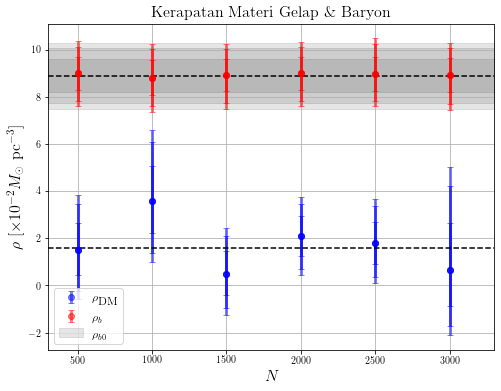

In [112]:
nlevel = np.arange(500, 3001, 500)
ns = np.linspace(300, 3300, 100)

fig, ax = plt.subplots(figsize=(8, 6))
ax.axhline(y=rhob0_mode, color='black', linestyle='--')
for i in range(3):
    low = np.array([err['low'][i] for err in rhoDM_errs])
    high = np.array([err['high'][i] for err in rhoDM_errs])
    dm_ax = ax.errorbar(nlevel, rhoDM_modes, yerr=[rhoDM_modes-low, high-rhoDM_modes], fmt='o', color='blue', capsize=3, alpha=0.5, elinewidth=3, markeredgewidth=1)
    low = np.array([err['low'][i] for err in rhob_errs])
    high = np.array([err['high'][i] for err in rhob_errs])
    rhob_ax = ax.errorbar(nlevel, rhob_modes, yerr=[rhob_modes-low, high-rhob_modes], fmt='o', color='red', capsize=3, alpha=0.5, elinewidth=3, markeredgewidth=1)
    rhob0_ax = ax.fill_between(ns, rhob0_low[i], rhob0_high[i], color='black', alpha=0.1)
    if i == 2:
        ax.legend([dm_ax, rhob_ax, rhob0_ax], 
                  [r'$\rho_{\textup{DM}}$', r'$\rho_{b}$', r'$\rho_{b0}$'],
                  loc='lower left', fontsize=12)
# real value
ax.axhline(y=1.6, color='black', linestyle='--')
ax.set_xlabel(r'$N$', fontsize=16)
ax.set_ylabel(r'$\rho$ [$\times 10^{-2}M_{\odot}\ $pc$^{-3}$]', fontsize=16)
ax.set_xlim(ns.min(), ns.max())
ax.set_title("Kerapatan Materi Gelap \& Baryon", fontsize=16)
ax.grid()
# fig.savefig('rm_2_z.pdf', dpi=300)
plt.show()

In [13]:
from tqdm import tqdm
from scipy.stats import skewnorm

rhoDM_v_n = []
rhoDM_fit_n = []
rhob_v_n = []
rhob_fit_n = []

for index in tqdm(range(len(dm_1_files))):
    df_dm = np.load(dm_1_files[index])
    rhob = df_dm[:, :, :12]
    rhob = rhob.reshape(-1, 12)
    rhob = rhob.sum(axis=1)/1E-2
    rhoDM = df_dm[:, :, 24].reshape(-1)/1E-2
    print("fitting...")
    rhoDM_f = skewnorm.fit(rhoDM)
    rhob_f = skewnorm.fit(rhob)
    rhoDM_fit_n.append(rhoDM_f)
    rhob_fit_n.append(rhob_f)

    print("calculating HDI...")
    rhoDM_low68, rhoDM_high68 = hdi(lambda x: skewnorm.pdf(x, *rhoDM_f), perc=0.68, res=1E3, min=-5, max=14)
    rhoDM_low90, rhoDM_high90 = hdi(lambda x: skewnorm.pdf(x, *rhoDM_f), perc=0.90, res=1E3, min=-5, max=14)
    rhoDM_low95, rhoDM_high95 = hdi(lambda x: skewnorm.pdf(x, *rhoDM_f), perc=0.95, res=1E3, min=-5, max=14)
    rhoDM_mode = find_max(lambda x: skewnorm.pdf(x, *rhoDM_f), x0=0.0)[0]
    rhoDM_v_n.append([rhoDM_mode, rhoDM_low68, rhoDM_high68, rhoDM_low90, rhoDM_high90, rhoDM_low95, rhoDM_high95])

    rhob_low68, rhob_high68 = hdi(lambda x: skewnorm.pdf(x, *rhob_f), perc=0.68, res=1E3, min=-5, max=14)
    rhob_low90, rhob_high90 = hdi(lambda x: skewnorm.pdf(x, *rhob_f), perc=0.90, res=1E3, min=-5, max=14)
    rhob_low95, rhob_high95 = hdi(lambda x: skewnorm.pdf(x, *rhob_f), perc=0.95, res=1E3, min=-5, max=14)
    rhob_mode = find_max(lambda x: skewnorm.pdf(x, *rhob_f), x0=0.0)[0]
    rhob_v_n.append([rhob_mode, rhob_low68, rhob_high68, rhob_low90, rhob_high90, rhob_low95, rhob_high95])

  0%|          | 0/6 [00:00<?, ?it/s]

fitting...
calculating HDI...


 17%|█▋        | 1/6 [00:31<02:37, 31.55s/it]

fitting...
calculating HDI...


 33%|███▎      | 2/6 [00:47<01:30, 22.60s/it]

fitting...
calculating HDI...


 50%|█████     | 3/6 [01:10<01:08, 22.78s/it]

fitting...
calculating HDI...


 67%|██████▋   | 4/6 [01:32<00:44, 22.34s/it]

fitting...
calculating HDI...


 83%|████████▎ | 5/6 [02:07<00:27, 27.05s/it]

fitting...
calculating HDI...


100%|██████████| 6/6 [02:23<00:00, 23.99s/it]


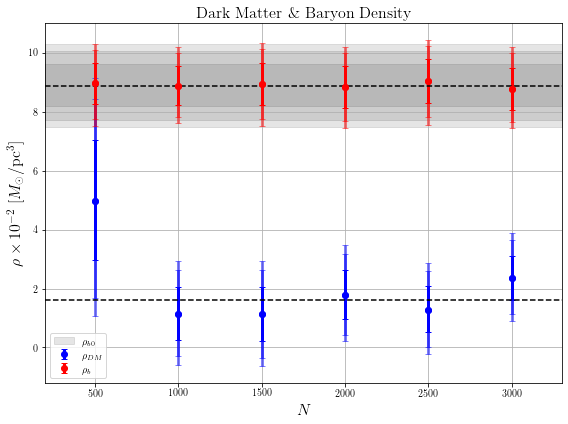

In [18]:
c = np.arange(500, 3001, 500)

rhoDM_v_n = np.array(rhoDM_v_n)
rhoDM_mode = rhoDM_v_n[:,0]
rhoDM_low68 = rhoDM_v_n[:,1]
rhoDM_high68 = rhoDM_v_n[:,2]
rhoDM_err_low68 = rhoDM_mode-rhoDM_low68
rhoDM_err_high68 = rhoDM_high68-rhoDM_mode
rhoDM_low90 = rhoDM_v_n[:,3]
rhoDM_high90 = rhoDM_v_n[:,4]
rhoDM_err_low90 = rhoDM_mode-rhoDM_low90
rhoDM_err_high90 = rhoDM_high90-rhoDM_mode
rhoDM_low95 = rhoDM_v_n[:,5]
rhoDM_high95 = rhoDM_v_n[:,6]
rhoDM_err_low95 = rhoDM_mode-rhoDM_low95
rhoDM_err_high95 = rhoDM_high95-rhoDM_mode

rhob_v_n = np.array(rhob_v_n)
rhob_mode = rhob_v_n[:,0]
rhob_low68 = rhob_v_n[:,1]
rhob_high68 = rhob_v_n[:,2]
rhob_err_low68 = rhob_mode-rhob_low68
rhob_err_high68 = rhob_high68-rhob_mode
rhob_low90 = rhob_v_n[:,3]
rhob_high90 = rhob_v_n[:,4]
rhob_err_low90 = rhob_mode-rhob_low90
rhob_err_high90 = rhob_high90-rhob_mode
rhob_low95 = rhob_v_n[:,5]
rhob_high95 = rhob_v_n[:,6]
rhob_err_low95 = rhob_mode-rhob_low95
rhob_err_high95 = rhob_high95-rhob_mode

# plot vertical line for each rho with respect to their c
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(c, rhoDM_mode, yerr=[rhoDM_err_low95, rhoDM_err_high95], fmt='o', color='blue', capsize=3, alpha=0.5, elinewidth=3, markeredgewidth=1)
ax.errorbar(c, rhoDM_mode, yerr=[rhoDM_err_low90, rhoDM_err_high90], fmt='o', color='blue', capsize=3, alpha=0.5, elinewidth=3, markeredgewidth=1)
ax.errorbar(c, rhoDM_mode, yerr=[rhoDM_err_low68, rhoDM_err_high68], fmt='o', color='blue', capsize=3, label=r'$\rho_{DM}$', elinewidth=3, markeredgewidth=1)
ax.errorbar(c, rhob_mode, yerr=[rhob_err_low95, rhob_err_high95], fmt='o', color='red', capsize=3, elinewidth=3, alpha=0.5, markeredgewidth=1)
ax.errorbar(c, rhob_mode, yerr=[rhob_err_low90, rhob_err_high90], fmt='o', color='red', capsize=3, elinewidth=3, alpha=0.5, markeredgewidth=1)
ax.errorbar(c, rhob_mode, yerr=[rhob_err_low68, rhob_err_high68], fmt='o', color='red', capsize=3, elinewidth=3, label=r'$\rho_{b}$', markeredgewidth=1)
ax.axhline(y=rhob0_mode, color='black', linestyle='--')
cs = np.linspace(200, 3300, 100)
ax.fill_between(cs, rhob0_low68, rhob0_high68, color='black', alpha=0.1)
ax.fill_between(cs, rhob0_low90, rhob0_high90, color='black', alpha=0.1)
ax.fill_between(cs, rhob0_low95, rhob0_high95, color='black', alpha=0.1, label=r'$\rho_{b0}$')
# ax.axhline(y=rhoDM_com_mode, color='black', linestyle='--')
# ax.fill_between(cs, rhoDM_com_low68, rhoDM_com_high68, color='black', alpha=0.1)
# ax.fill_between(cs, rhoDM_com_low90, rhoDM_com_high90, color='black', alpha=0.1)
# ax.fill_between(cs, rhoDM_com_low95, rhoDM_com_high95, color='black', alpha=0.2, label=r'$\rho_{\textup{comb,DM}}$')
ax.axhline(y=1.6, color='black', linestyle='--')
ax.set_xlabel(r'$N$', fontsize=16)
ax.set_ylabel(r'$\rho\times 10^{-2}$ [$M_{\odot}/$pc$^{3}$]', fontsize=16)
ax.set_xlim(200, 3300)
# ax.set_ylim(-5.0, 14.0)
ax.set_title("Dark Matter \& Baryon Density", fontsize=16)
ax.grid()
ax.legend(fontsize=10)
plt.tight_layout()
plt.savefig('rhoDM_n.pdf', dpi=200)
plt.show()

In [20]:
for i, n in enumerate([500, 1000, 1500, 2000, 2500, 3000]):
    print(f"{n} & {rhoDM_mode[i]:.2f} & [{rhoDM_low68[i]:.2f}, {rhoDM_high68[i]:.2f}] & [{rhoDM_low90[i]:.2f}, {rhoDM_high90[i]:.2f}] & [{rhoDM_low95[i]:.2f}, {rhoDM_high95[i]:.2f}] \\\\")

500 & 4.98 & [2.97, 7.06] & [1.68, 8.45] & [1.07, 9.13] \\
1000 & 1.13 & [0.25, 2.04] & [-0.30, 2.65] & [-0.59, 2.93] \\
1500 & 1.12 & [0.21, 2.04] & [-0.36, 2.65] & [-0.64, 2.93] \\
2000 & 1.79 & [0.97, 2.63] & [0.44, 3.18] & [0.21, 3.46] \\
2500 & 1.27 & [0.52, 2.08] & [0.02, 2.61] & [-0.23, 2.85] \\
3000 & 2.36 & [1.60, 3.12] & [1.12, 3.63] & [0.90, 3.88] \\
